In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy.optimize as so
from math import cos, sin
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# %% Read in data
full = Table.read('full.fits', format = 'fits')

In [3]:
# %% Make subset with only objid = -1 and only galaxies
galaxy = full[full['CLASS'] == 'GALAXY']
galaxy = galaxy[galaxy['OBJID']!= -1]

In [4]:
# %% Find RA and DEC
RA = galaxy['RA']
DEC = galaxy['DEC']

Plot 3D map of galaxies using Cartesian coordinates

In [51]:
# %% Convert from RA and DEC to Cartesian
# code from https://www.reddit.com/r/astrophysics/comments/eo1jw2/plotting_in_3d_cartesian_plane/
from astropy import units as u
from astropy.coordinates import SkyCoord

# create coordinate object from ra, dec, dist
# you'll have to figure out how to convert from redshift to distance to plug it in here
coord = SkyCoord(ra=RA*u.degree, dec=DEC*u.degree)

# get xyz cartesian dimensions 
x = coord.cartesian.x.value
y = coord.cartesian.y.value
z = coord.cartesian.z.value

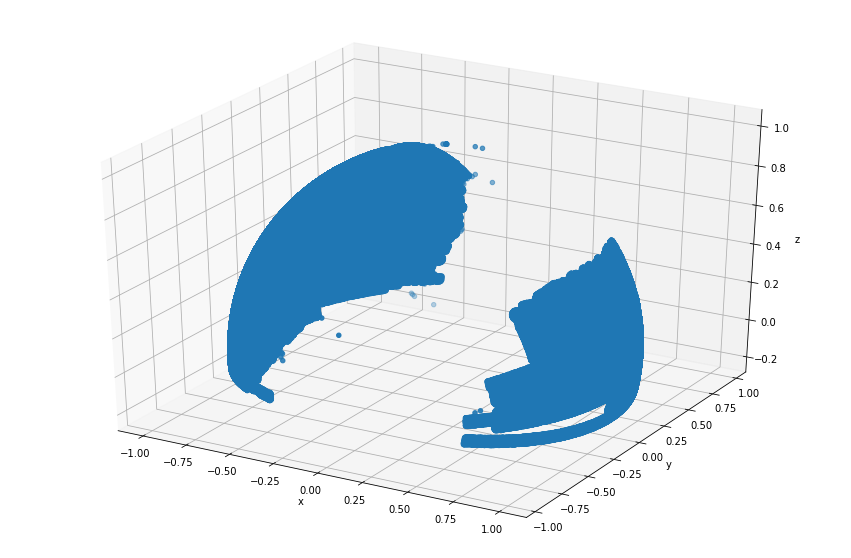

In [54]:
# %% Plot 3D map
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Plot scatter plot of DEC vs RA for galaxies with OBJID != -1

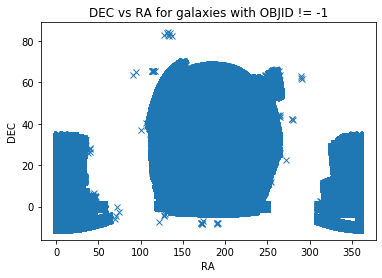

In [6]:
# %% Plot scatter plot of DEC vs RA for galaxies with OBJID != -1
plt.figure()
plt.plot(RA, DEC, 'x')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('DEC vs RA for galaxies with OBJID != -1')
plt.show()

Scatter plot is too dense, use 2D density contour plot instead

Find the 2D histogram of RA and DEC. Histogram is normalised i.e. returns sample density.

From https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html:
Please note that the histogram does not follow the Cartesian convention where x values are on the abscissa and y values on the ordinate axis. Rather, x is histogrammed along the first dimension of the array (vertical), and y along the second dimension of the array (horizontal).

In [17]:
nbins_x = 100
nbins_y = 100
H, xedges, yedges = np.histogram2d(RA, DEC, bins=(nbins_x,nbins_y), normed=True)
x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))
print(H.shape)
print((x_bin_sizes*y_bin_sizes).shape)

(100, 100)
(100, 100)


Find the joint PDF

In [16]:
pdf = (H*(x_bin_sizes*y_bin_sizes))
print(pdf.shape)

(100, 100)


Find 1 (68%), 2 (95%), and 3 (99%) sigma levels. These are the values of x for which the true mean lies in the interval [x, maximum/end of range] with the corresponding %. These will be used as the contour levels. x is found through optimisation (Brent's method).

In [21]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
levels = [three_sigma, two_sigma, one_sigma]
print(levels)

[8.267925909427244e-05, 0.0001497749909067556, 0.0002553966606536961]


Find X and Y as the bin centres, and Z as the transpose of the PDF.

In [22]:
X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
Z = pdf.T

Plot 2D density contour graph

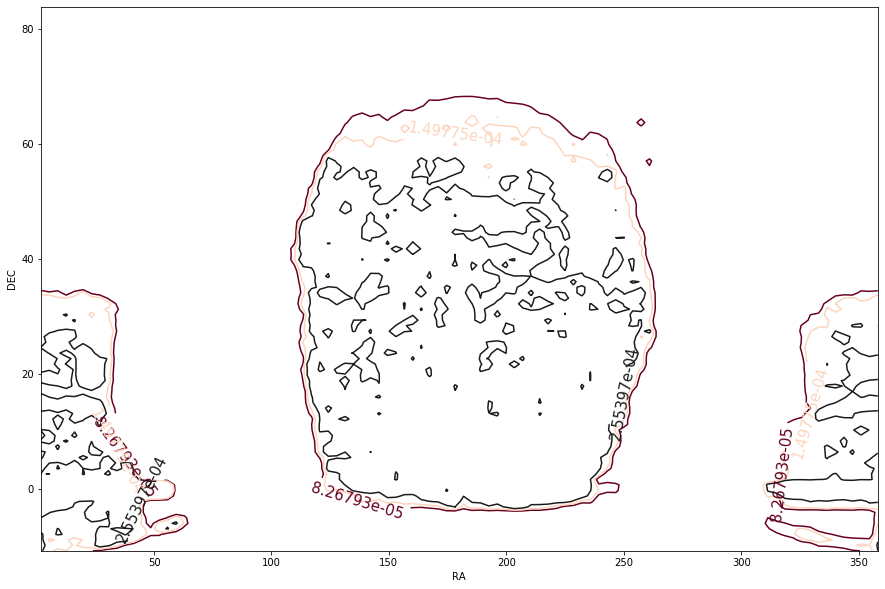

1 sigma: 2.55397e-04
2 sigma: 1.49775e-04
3 sigma: 8.26793e-05


In [47]:
plt.figure(figsize=(15,10))
contour = plt.contour(X, Y, Z, levels=levels, origin="lower", cmap = 'RdGy')
plt.clabel(contour, inline = 1, fontsize = 15, fmt = '%.5e')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()
for i in range(len(levels)):
    print(f'{i+1} sigma: {levels[len(levels)-i-1]:.5e}')

Plot 2D density contour plot with individual histograms for RA and DEC

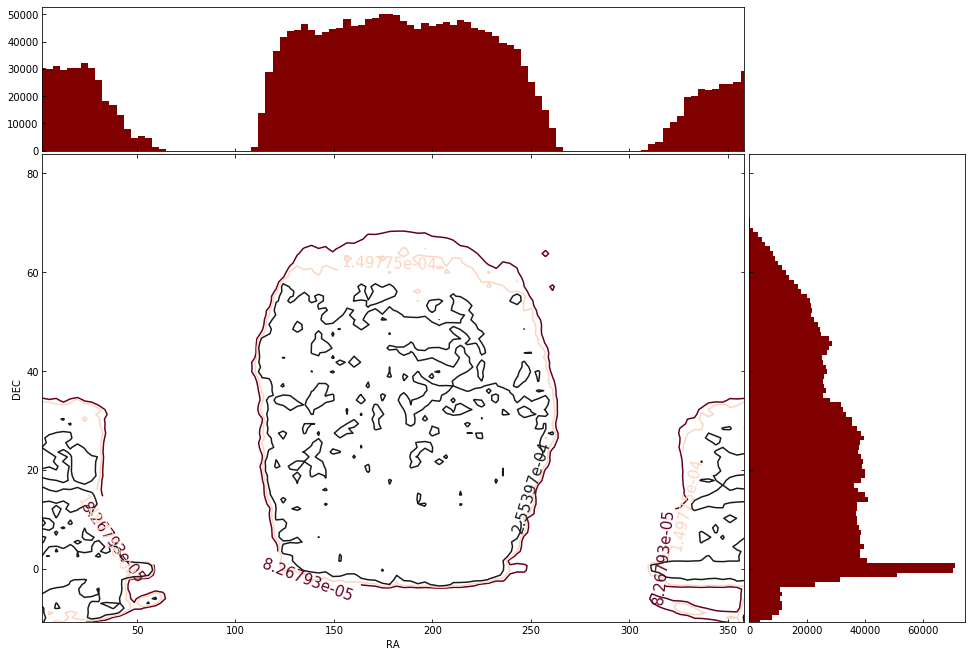

1 sigma: 2.55397e-04
2 sigma: 1.49775e-04
3 sigma: 8.26793e-05


In [60]:
# code from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_hist.html

# Define axes positions
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_contour = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.figure(figsize=(15, 10))

# Make axes
ax_contour = plt.axes(rect_contour)
ax_contour.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

contour = ax_contour.contour(X, Y, Z, levels=levels, cmap = 'RdGy')
ax_contour.clabel(contour, inline = 1, fontsize = 15, fmt = '%.5e')

ax_histx.hist(RA, bins = nbins_x, color = 'maroon')
ax_histy.hist(DEC, bins = nbins_y, orientation='horizontal', color = 'maroon')

ax_histx.set_xlim(ax_contour.get_xlim())
ax_histy.set_ylim(ax_contour.get_ylim())

ax_contour.set_xlabel('RA')
ax_contour.set_ylabel('DEC')
plt.show()
for i in range(len(levels)):
    print(f'{i+1} sigma: {levels[len(levels)-i-1]:.5e}')